# Procesy stabulne Lecy'ego

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_2D(W, tytul):
    # Rysowanie trajektorii procesu Wienera
    n = len(W)
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 1, n), W)
    plt.title(tytul)
    plt.xlabel("t")
    plt.ylabel("W(t)")
    plt.grid(True)
    plt.show()

def plot_3D(t, X_t, Y_t, tytul_x, tytul_y):

    # Tworzenie wykresu 3D
    fig = plt.figure(figsize=(14, 8))
    
    ax = fig.add_subplot(111, projection='3d')
    
    # Rysowanie wykresu
    ax.plot(t, X_t, Y_t)

    # Etykiety osi
    ax.set_xlabel('t')
    ax.set_ylabel(tytul_x)
    ax.set_zlabel(tytul_y)

    # Wyświetlenie wykresu
    plt.show()
    
    return

In [2]:
def generate_levy_trajectory(n, alpha, beta):
    """
    Generuje trajektorię procesu Lévy'ego.
    
    :param n: Liczba kroków.
    :param alpha: Parametr skali (stabilności), 0 < alpha <= 2.
    :param beta: Parametr asymetrii, -1 <= beta <= 1.
    :return: Trajektoria procesu Lévy'ego.
    """
    if not (0 < alpha <= 2):
        raise ValueError("Parametr alpha musi być w zakresie (0, 2].")

    if not (-1 <= beta <= 1):
        raise ValueError("Parametr beta musi być w zakresie [-1, 1].")

    # Generowanie skoków z rozkładu Lévy'ego
    sigma = (1 - beta ** 2) ** (1 / (2 * alpha))
    uniform_randoms = np.random.uniform(-np.pi / 2, np.pi / 2, n)
    exponential_randoms = np.random.exponential(scale=(1 / alpha), size=n)
    jumps = sigma * np.tan(alpha * uniform_randoms) + beta * sigma * \
            (np.cos(alpha * uniform_randoms) - 1) / np.cos(uniform_randoms) / exponential_randoms

    # Sumowanie skoków do utworzenia trajektorii
    trajectory = np.cumsum(jumps)

    return trajectory

In [3]:
# wybór parametrów

n = 1000
alpha = 1.5
beta = 0
t = np.linspace(0, n, n)

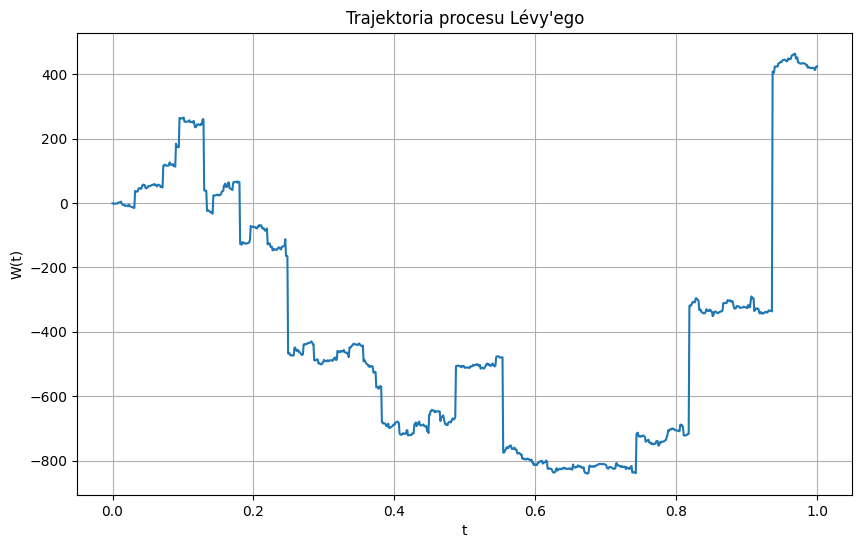

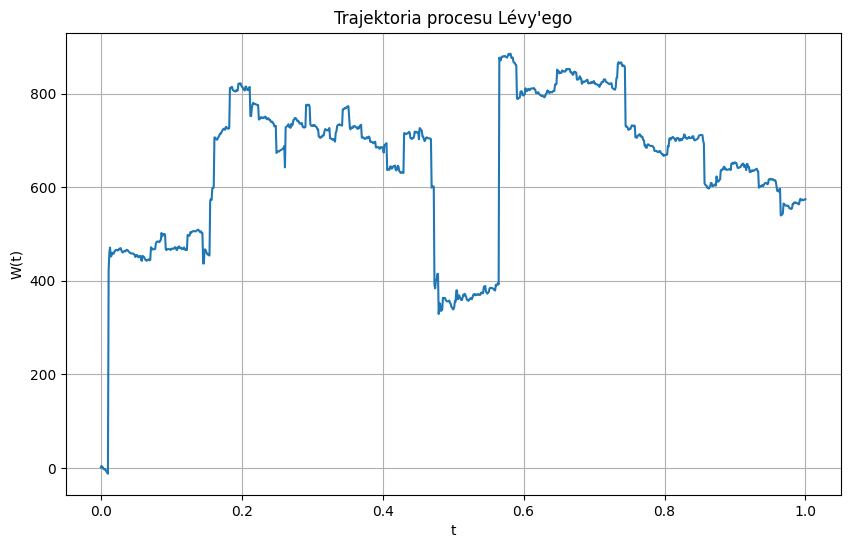

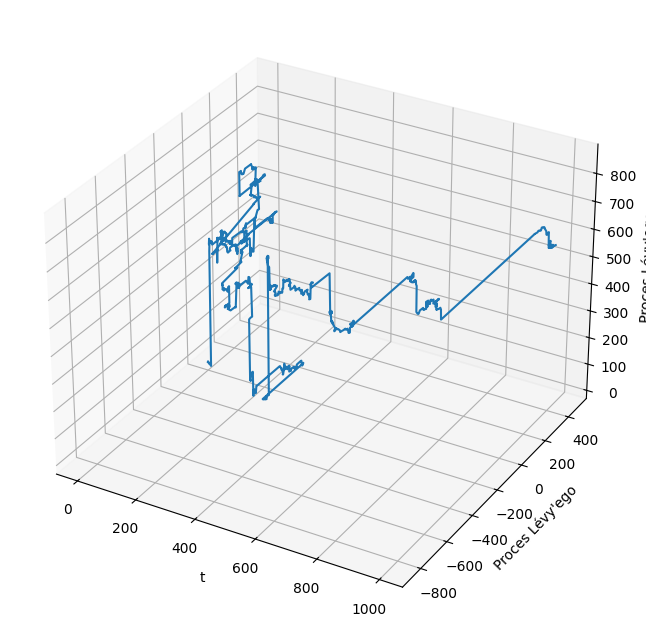

In [4]:
levy_trajectory_1 = generate_levy_trajectory(n, alpha, beta)
plot_2D(levy_trajectory_1, 'Trajektoria procesu Lévy\'ego')

levy_trajectory_2 = generate_levy_trajectory(n, alpha, beta)
plot_2D(levy_trajectory_2, 'Trajektoria procesu Lévy\'ego')

plot_3D(t, levy_trajectory_1, levy_trajectory_2, 'Proces Lévy\'ego', 'Proces Lévy\'ego')

# Zastosowania procesów Levy'ego

TODO

## Model dyfuzji skoków Mertona (Merton's Jump Difiussion Model)

Model dyfuzji skoków Mertona stanowi rozszerzenie popularnego modelu Black-Scholes. Główną wadą modelu BS jest fakt, że jego symulacja oparta jest na gemetrychnych ruchach Browna, a więc zakłada, że Volatility jest stałe, co w rzeczywistości nie zawsze jest prawdą. Zdarzenia takie jak bankructwa róznych przedsiębiorstw, wydarzenia polityczne czy inne zewnętrze czynniki mogą drastycznie wpływać na wartość akcji, co powoduje nagłe skoki widoczne na wykresach kursu danej akcji od czasu. Aby uwzględnić te nagłe, gwałtowne zmiany powstał Nodel Mertona oparty na procesach Levy'ego.

Model ten wyróżnia dwa warianty zmian w ceniach akcji:
1. ***Wibracje normalne*** - reprezentowane proprzez ruch Browna (analogiczne do modelu BS)
2. ***Wibracjie abnormalne*** - zmiany nieciągłe, cechujące się dużymi, nagłymi skokami (niemożliwe do reprezentacji za pomocą rucu Browna)

Aby być w stanie rperezentować obydwa rodzaje zmian model wykorzystuje procesy Levy'ego, które są uogólnieniem ruchów Browna i pozawlają na symulację częstych dużych skoków.

### Rozwiązanie monte carlo


Text(0.5, 1.0, 'Jump Diffusion Process')

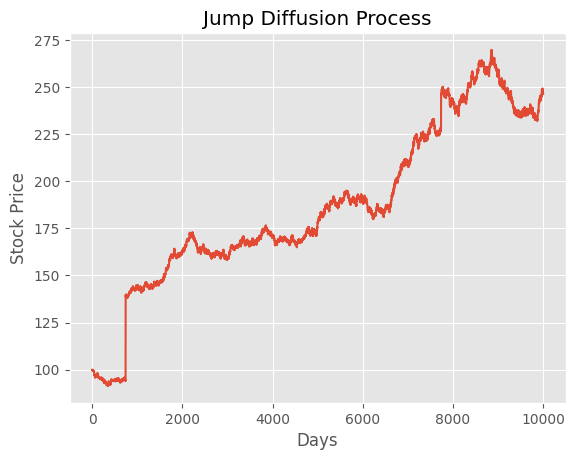

In [7]:
plt.style.use('ggplot')

def merton_jump_paths(S, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size),
                         np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S


S = 100 # current stock price
T = 1 # time to maturity
r = 0.02 # risk free rate
m = 0 # meean of jump size
v = 0.3 # standard deviation of jump
lam =1 # intensity of jump i.e. number of jumps per annum
steps =10000 # time steps
Npaths = 1 # number of paths to simulate
sigma = 0.2 # annaul standard deviation , for weiner process

j = merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths)

plt.plot(j)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process')

### Rozwiązanie alternawyne (Closed Form Solution)

In [8]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    
    

def merton_jump_call(S, K, T, r, sigma, m , v, lam):
    p = 0
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = np.math.factorial(k)
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact))  * BS_CALL(S, K, T, r_k, sigma_k)
    
    return p 


def merton_jump_put(S, K, T, r, sigma, m , v, lam):
    p = 0 # price of option
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = np.math.factorial(k) # 
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact)) \
                    * BS_PUT(S, K, T, r_k, sigma_k)
    return p 

### Porównanie obydwu metod do metody Black Scholes

In [9]:
S = 100 # current stock price
T = 1 # time to maturity
r = 0.02 # risk free rate
m = 0 # meean of jump size
v = 0.3 # standard deviation of jump
lam = 1 # intensity of jump i.e. number of jumps per annum
steps =255 # time steps
Npaths =200000 # number of paths to simulate
sigma = 0.2 # annaul standard deviation , for weiner process
K =100
np.random.seed(3)
j = merton_jump_paths(S, T, r, sigma, lam, m, v, steps, Npaths) #generate jump diffusion paths

mcprice = np.maximum(j[-1]-K,0).mean() * np.exp(-r*T) # calculate value of call

cf_price =  merton_jump_call(S, K, T, r, sigma, np.exp(m+v**2*0.5) , v, lam)

print('Merton Price =', cf_price)
print('Monte Carlo Merton Price =', mcprice)
print('Black Scholes Price =', BS_CALL(S,K,T,r, sigma))

#Merton Price = 14.500570058304778
#Monte Carlo Merton Price = 14.597509592911369
#Black Scholes Price = 8.916037278572539

Merton Price = 14.500570058304778
Monte Carlo Merton Price = 14.597509592911369
Black Scholes Price = 8.916037278572539


C:\Users\karol\AppData\Local\Temp\ipykernel_1756\2592729197.py:22: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  k_fact = np.math.factorial(k)
